In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input/ieee-fraud-detection/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ieee-fraud-detection/sample_submission.csv
/kaggle/input/ieee-fraud-detection/test_identity.csv
/kaggle/input/ieee-fraud-detection/train_identity.csv
/kaggle/input/ieee-fraud-detection/test_transaction.csv
/kaggle/input/ieee-fraud-detection/train_transaction.csv


In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

# import warnings
# warnings.simplefilter('ignore')

from sklearn import set_config
set_config(transform_output="pandas")

## 1. Data Loading and test/train split

Load the datasets and merge them.

In [4]:
df_transaction = pd.read_csv('/kaggle/input/ieee-fraud-detection/train_transaction.csv')
df_identity = pd.read_csv('/kaggle/input/ieee-fraud-detection/train_identity.csv')
df = pd.merge(df_transaction,df_identity,how="left",on="TransactionID")
print(f'Dimensions of the combined data set: {df.shape}')

del df_transaction, df_identity

Dimensions of the combined data set: (590540, 434)


In [5]:
from sklearn.model_selection import train_test_split

X = df.drop('isFraud', axis=1)
y = df['isFraud']
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)
print(f'Dimensions of the train dataset is {X_train.shape} and {y_train.shape}')
print(f'Dimensions of the validation dataset is {X_valid.shape} and {y_valid.shape}')

del X, y

Dimensions of the train dataset is (472432, 433) and (472432,)
Dimensions of the validation dataset is (118108, 433) and (118108,)


## 2. Dagshub and MLflow

In [6]:
!pip install dagshub 
!pip install mlflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 260.1/260.1 kB 6.1 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.2/203.2 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.3/74.3 kB 4.0 MB/s eta 0:00:00
  Attempting uninstall: dacite
    Found existing installation: dacite 1.9.2
    Uninstalling dacite-1.9.2:
      Successfully uninstalled dacite-1.9.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ydata-profiling 4.16.1 requires dacite>=1.8, but you have dacite 1.6.0 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.0/29.0 MB 46.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 84.7 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 4.7 MB/s eta 0:00:00
   

In [7]:
import dagshub
dagshub.init(repo_owner='zhorzholianimate', repo_name='IEEE-CIS-Fraud-Detection', mlflow=True)

❗❗❗ AUTHORIZATION REQUIRED ❗❗❗

Output()



Open the following link in your browser to authorize the client:
https://dagshub.com/login/oauth/authorize?state=1457f0a6-7c4c-4c11-9705-a616b905a48b&client_id=32b60ba385aa7cecf24046d8195a71c07dd345d9657977863b52e7748e0f0f28&middleman_request_id=57bd1fa827853a2cd510a106fc6ea05c5d93f98519e1b3502dd8071bca786ce8




Accessing as zhorzholianimate

Initialized MLflow to track repo "zhorzholianimate/IEEE-CIS-Fraud-Detection"

Repository zhorzholianimate/IEEE-CIS-Fraud-Detection initialized!

In [8]:
import mlflow
mlflow.set_experiment("Random_Forest_training")

2025/04/26 17:31:40 INFO mlflow.tracking.fluent: Experiment with name 'Random_Forest_training' does not exist. Creating a new experiment.


<Experiment: artifact_location='mlflow-artifacts:/158c9a2cd08d46e5a432f0f27bdcaa8f', creation_time=1745688700167, experiment_id='2', last_update_time=1745688700167, lifecycle_stage='active', name='Random_Forest_training', tags={}>

## 3. Cleaning

We will drop columns in which more than 80% of values are missing.

In [9]:
from sklearn.base import BaseEstimator, TransformerMixin

class DropHighNaNColumns(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=0.8):
        self.threshold = threshold
        self.cols_to_drop = []

    def fit(self, X, y=None):
        missing_ratio = pd.DataFrame(X).isnull().mean()
        self.cols_to_drop = missing_ratio[missing_ratio > self.threshold].index.tolist()
        return self

    def transform(self, X):
        return pd.DataFrame(X).drop(columns=self.cols_to_drop)

Also, we will use following imputer, as it is the best practice for random forest in general.

In [15]:
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import make_column_selector

imputer = ColumnTransformer(transformers=[
            ('num', SimpleImputer(strategy="median"), make_column_selector(dtype_include=np.number)),
            ('cat', SimpleImputer(strategy="constant", fill_value='unknown'), make_column_selector(dtype_include=object))
        ])
cleaner = Pipeline([
    ('highNA', DropHighNaNColumns()),
    ('imputer', imputer),
])

X_train_clean = cleaner.fit_transform(X_train, y_train)
X_valid_clean = cleaner.transform(X_valid)

X_train_clean

,num__TransactionID,num__TransactionDT,num__TransactionAmt,num__card1,num__card2,num__card3,num__card5,num__addr1,num__addr2,num__dist1,...,cat__id_16,cat__id_28,cat__id_29,cat__id_31,cat__id_35,cat__id_36,cat__id_37,cat__id_38,cat__DeviceType,cat__DeviceInfo
5307,2992307.0,174911.0,59.000,4988.0,334.0,150.0,226.0,315.0,87.0,42.0,...,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown
191582,3178582.0,4301977.0,23.378,3867.0,296.0,185.0,226.0,299.0,87.0,8.0,...,NotFound,New,NotFound,chrome 63.0,F,F,T,F,desktop,unknown
260168,3247168.0,6229929.0,35.950,12577.0,268.0,150.0,166.0,476.0,87.0,8.0,...,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown
18516,3005516.0,497176.0,100.000,6019.0,583.0,150.0,226.0,126.0,87.0,8.0,...,NotFound,Found,Found,chrome 62.0,T,F,T,F,desktop,Windows
47538,3034538.0,1124702.0,75.000,16075.0,514.0,150.0,102.0,325.0,87.0,8.0,...,Found,Found,Found,chrome 62.0 for android,T,F,T,T,mobile,SM-G950U Build/NRD90M
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110268,3097268.0,2157580.0,25.000,16796.0,555.0,210.0,137.0,296.0,102.0,8.0,...,Found,Found,Found,chrome 63.0,T,F,T,T,desktop,Windows
259178,3246178.0,6213562.0,357.950,16727.0,111.0,150.0,226.0,325.0,87.0,8.0,...,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown
365838,3352838.0,9076295.0,156.000,3283.0,555.0,150.0,226.0,191.0,87.0,1.0,...,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown
131932,3118932.0,2614452.0,59.000,9500.0,321.0,150.0,226.0,204.0,87.0,8.0,...,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown


In [16]:
X_valid_clean

,num__TransactionID,num__TransactionDT,num__TransactionAmt,num__card1,num__card2,num__card3,num__card5,num__addr1,num__addr2,num__dist1,...,cat__id_16,cat__id_28,cat__id_29,cat__id_31,cat__id_35,cat__id_36,cat__id_37,cat__id_38,cat__DeviceType,cat__DeviceInfo
470624,3457624.0,12153579.0,724.000,7826.0,481.0,150.0,224.0,387.0,87.0,8.0,...,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown
565820,3552820.0,15005886.0,108.500,12544.0,321.0,150.0,226.0,476.0,87.0,0.0,...,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown
284083,3271083.0,6970178.0,47.950,9400.0,111.0,150.0,224.0,315.0,87.0,6.0,...,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown
239689,3226689.0,5673658.0,100.599,15885.0,545.0,185.0,138.0,299.0,87.0,8.0,...,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown
281855,3268855.0,6886780.0,107.950,15497.0,490.0,150.0,226.0,299.0,87.0,8.0,...,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
373780,3360780.0,9314548.0,113.000,2242.0,555.0,150.0,226.0,204.0,87.0,8.0,...,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown
245203,3232203.0,5843908.0,117.000,8763.0,555.0,150.0,226.0,231.0,87.0,52.0,...,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown
450760,3437760.0,11491417.0,59.513,16136.0,204.0,185.0,138.0,299.0,87.0,8.0,...,Found,Found,Found,chrome 65.0 for android,F,F,T,F,mobile,CAM-L03 Build/HUAWEICAM-L03
529422,3516422.0,13923492.0,21.580,15885.0,545.0,185.0,138.0,299.0,87.0,8.0,...,Found,Found,Found,chrome 50.0 for android,F,F,T,F,mobile,SM-G531H Build/LMY48B


Record the result of cleaning to MLflow.

In [20]:
import mlflow.sklearn
from sklearn.metrics import roc_curve, auc, precision_recall_curve, precision_score, recall_score, average_precision_score
from sklearn.metrics import confusion_matrix


with mlflow.start_run(run_name="RandomForest_Cleaning"):
    valid_data_summary = pd.DataFrame(X_valid_clean).describe().T
    valid_data_summary.to_csv("valid_data_summary.csv", index=True)
    mlflow.log_artifact("valid_data_summary.csv") 

    top_features = ['num__TransactionID', 'num__TransactionAmt', 'num__card1', 'num__card2', 'num__card3', 'num__card5', 'num__addr1', 'num__addr2', 'num__dist1']
    
    pd.DataFrame(X_train_clean).describe().T.to_csv("train_clean_summary.csv")
    mlflow.log_artifact("train_clean_summary.csv")
    X_train_clean[top_features].hist(bins=30, figsize=(12, 6))
    plt.suptitle("X_train_clean Top 10 Feature Distributions (Highest Variance)")
    plt.savefig("train_data_top_features_histograms.png")
    mlflow.log_artifact("train_data_top_features_histograms.png")
    plt.close() 
    plt.figure(figsize=(12, 6))
    X_valid_clean[top_features].hist(bins=30, figsize=(12, 6))
    plt.suptitle("X_valid_clean Top 10 Feature Distributions (Highest Variance)")
    plt.savefig("valid_data_top_features_histograms.png")
    mlflow.log_artifact("valid_data_top_features_histograms.png")
    plt.close() 
    corr_matrix = pd.DataFrame(X_train_clean[top_features]).corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', cbar=True, xticklabels=top_features, yticklabels=top_features)
    plt.title("Correlation Heatmap of Top 10 Features")
    plt.savefig("correlation_heatmap.png")
    mlflow.log_artifact("correlation_heatmap.png")
    plt.close() 

🏃 View run RandomForest_Cleaning at: https://dagshub.com/zhorzholianimate/IEEE-CIS-Fraud-Detection.mlflow/#/experiments/2/runs/b96516793d6b44989cb647252e998444
🧪 View experiment at: https://dagshub.com/zhorzholianimate/IEEE-CIS-Fraud-Detection.mlflow/#/experiments/2


<Figure size 1200x600 with 0 Axes>

### 4. Feature Engineering

I think using a label encoder is the best approach for tree-based structures.

In [35]:
class FrequencyEncoder(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.mapping_ = {}
        self.cat_columns_ = X.select_dtypes(include=['object', 'category']).columns
        for column in self.cat_columns_:
            freq = X[column].value_counts() / len(X)
            self.mapping_[column] = freq
        return self
    
    def transform(self, X):
        X_transformed = X.copy()
        for column in self.cat_columns_:
            X_transformed[column] = X[column].map(self.mapping_[column]).fillna(0)
        return X_transformed

In [36]:
from sklearn.preprocessing import LabelEncoder

encoder = FrequencyEncoder()
X_train_encoded = encoder.fit_transform(X_train_clean)
X_valid_encoded = encoder.transform(X_valid_clean)
X_train_encoded

,num__TransactionID,num__TransactionDT,num__TransactionAmt,num__card1,num__card2,num__card3,num__card5,num__addr1,num__addr2,num__dist1,...,cat__id_16,cat__id_28,cat__id_29,cat__id_31,cat__id_35,cat__id_36,cat__id_37,cat__id_38,cat__DeviceType,cat__DeviceInfo
5307,2992307.0,174911.0,59.000,4988.0,334.0,150.0,226.0,315.0,87.0,42.0,...,0.781130,0.761326,0.761326,0.762516,0.761318,0.761318,0.761318,0.761318,0.761619,0.799122
191582,3178582.0,4301977.0,23.378,3867.0,296.0,185.0,226.0,299.0,87.0,8.0,...,0.106767,0.109849,0.112061,0.037294,0.107220,0.227027,0.186950,0.125432,0.144000,0.799122
260168,3247168.0,6229929.0,35.950,12577.0,268.0,150.0,166.0,476.0,87.0,8.0,...,0.781130,0.761326,0.761326,0.762516,0.761318,0.761318,0.761318,0.761318,0.761619,0.799122
18516,3005516.0,497176.0,100.000,6019.0,583.0,150.0,226.0,126.0,87.0,8.0,...,0.106767,0.128825,0.126613,0.012135,0.131462,0.227027,0.186950,0.125432,0.144000,0.080687
47538,3034538.0,1124702.0,75.000,16075.0,514.0,150.0,102.0,325.0,87.0,8.0,...,0.112103,0.128825,0.126613,0.003495,0.131462,0.227027,0.186950,0.113250,0.094382,0.000483
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110268,3097268.0,2157580.0,25.000,16796.0,555.0,210.0,137.0,296.0,102.0,8.0,...,0.112103,0.128825,0.126613,0.037294,0.131462,0.227027,0.186950,0.113250,0.144000,0.080687
259178,3246178.0,6213562.0,357.950,16727.0,111.0,150.0,226.0,325.0,87.0,8.0,...,0.781130,0.761326,0.761326,0.762516,0.761318,0.761318,0.761318,0.761318,0.761619,0.799122
365838,3352838.0,9076295.0,156.000,3283.0,555.0,150.0,226.0,191.0,87.0,1.0,...,0.781130,0.761326,0.761326,0.762516,0.761318,0.761318,0.761318,0.761318,0.761619,0.799122
131932,3118932.0,2614452.0,59.000,9500.0,321.0,150.0,226.0,204.0,87.0,8.0,...,0.781130,0.761326,0.761326,0.762516,0.761318,0.761318,0.761318,0.761318,0.761619,0.799122


In [37]:
X_valid_encoded

,num__TransactionID,num__TransactionDT,num__TransactionAmt,num__card1,num__card2,num__card3,num__card5,num__addr1,num__addr2,num__dist1,...,cat__id_16,cat__id_28,cat__id_29,cat__id_31,cat__id_35,cat__id_36,cat__id_37,cat__id_38,cat__DeviceType,cat__DeviceInfo
470624,3457624.0,12153579.0,724.000,7826.0,481.0,150.0,224.0,387.0,87.0,8.0,...,0.781130,0.761326,0.761326,0.762516,0.761318,0.761318,0.761318,0.761318,0.761619,0.799122
565820,3552820.0,15005886.0,108.500,12544.0,321.0,150.0,226.0,476.0,87.0,0.0,...,0.781130,0.761326,0.761326,0.762516,0.761318,0.761318,0.761318,0.761318,0.761619,0.799122
284083,3271083.0,6970178.0,47.950,9400.0,111.0,150.0,224.0,315.0,87.0,6.0,...,0.781130,0.761326,0.761326,0.762516,0.761318,0.761318,0.761318,0.761318,0.761619,0.799122
239689,3226689.0,5673658.0,100.599,15885.0,545.0,185.0,138.0,299.0,87.0,8.0,...,0.781130,0.761326,0.761326,0.762516,0.761318,0.761318,0.761318,0.761318,0.761619,0.799122
281855,3268855.0,6886780.0,107.950,15497.0,490.0,150.0,226.0,299.0,87.0,8.0,...,0.781130,0.761326,0.761326,0.762516,0.761318,0.761318,0.761318,0.761318,0.761619,0.799122
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
373780,3360780.0,9314548.0,113.000,2242.0,555.0,150.0,226.0,204.0,87.0,8.0,...,0.781130,0.761326,0.761326,0.762516,0.761318,0.761318,0.761318,0.761318,0.761619,0.799122
245203,3232203.0,5843908.0,117.000,8763.0,555.0,150.0,226.0,231.0,87.0,52.0,...,0.781130,0.761326,0.761326,0.762516,0.761318,0.761318,0.761318,0.761318,0.761619,0.799122
450760,3437760.0,11491417.0,59.513,16136.0,204.0,185.0,138.0,299.0,87.0,8.0,...,0.112103,0.128825,0.126613,0.005666,0.107220,0.227027,0.186950,0.125432,0.094382,0.000292
529422,3516422.0,13923492.0,21.580,15885.0,545.0,185.0,138.0,299.0,87.0,8.0,...,0.112103,0.128825,0.126613,0.000246,0.107220,0.227027,0.186950,0.125432,0.094382,0.000713


Also, we will filter columns based on the variance and the corelation. In addition, we will use Random Forest's built in feature importance method. We will try and remove features that are not important for random forest.

In [48]:
from sklearn.ensemble import RandomForestClassifier

class RandomForestFeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, n_estimators=100, max_depth=7, importance_threshold=1e-4, random_state=42):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.importance_threshold = importance_threshold
        self.random_state = random_state
        
    def fit(self, X, y):
        self.model_ = RandomForestClassifier(
            n_estimators=self.n_estimators,
            max_depth=self.max_depth,
            random_state=self.random_state,
            n_jobs=-1
        )
        self.model_.fit(X, y)
        self.importances_ = pd.Series(self.model_.feature_importances_, index=X.columns)
        self.selected_features_ = self.importances_[self.importances_ > self.importance_threshold].index
        return self
    
    def transform(self, X):
        return X[self.selected_features_]

In [49]:
my_filter = RandomForestFeatureSelector()
X_train_t = my_filter.fit_transform(X_train_encoded, y_train)
X_valid_t = my_filter.transform(X_valid_encoded)
X_train_t

,num__TransactionID,num__TransactionDT,num__TransactionAmt,num__card1,num__card2,num__card3,num__card5,num__addr1,num__C1,num__C2,...,cat__id_15,cat__id_16,cat__id_28,cat__id_29,cat__id_31,cat__id_35,cat__id_36,cat__id_38,cat__DeviceType,cat__DeviceInfo
5307,2992307.0,174911.0,59.000,4988.0,334.0,150.0,226.0,315.0,2.0,1.0,...,0.761318,0.781130,0.761326,0.761326,0.762516,0.761318,0.761318,0.761318,0.761619,0.799122
191582,3178582.0,4301977.0,23.378,3867.0,296.0,185.0,226.0,299.0,1.0,1.0,...,0.104411,0.106767,0.109849,0.112061,0.037294,0.107220,0.227027,0.125432,0.144000,0.799122
260168,3247168.0,6229929.0,35.950,12577.0,268.0,150.0,166.0,476.0,6.0,5.0,...,0.761318,0.781130,0.761326,0.761326,0.762516,0.761318,0.761318,0.761318,0.761619,0.799122
18516,3005516.0,497176.0,100.000,6019.0,583.0,150.0,226.0,126.0,1.0,1.0,...,0.104411,0.106767,0.128825,0.126613,0.012135,0.131462,0.227027,0.125432,0.144000,0.080687
47538,3034538.0,1124702.0,75.000,16075.0,514.0,150.0,102.0,325.0,1.0,1.0,...,0.114459,0.112103,0.128825,0.126613,0.003495,0.131462,0.227027,0.113250,0.094382,0.000483
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110268,3097268.0,2157580.0,25.000,16796.0,555.0,210.0,137.0,296.0,2.0,1.0,...,0.114459,0.112103,0.128825,0.126613,0.037294,0.131462,0.227027,0.113250,0.144000,0.080687
259178,3246178.0,6213562.0,357.950,16727.0,111.0,150.0,226.0,325.0,1.0,1.0,...,0.761318,0.781130,0.761326,0.761326,0.762516,0.761318,0.761318,0.761318,0.761619,0.799122
365838,3352838.0,9076295.0,156.000,3283.0,555.0,150.0,226.0,191.0,6.0,4.0,...,0.761318,0.781130,0.761326,0.761326,0.762516,0.761318,0.761318,0.761318,0.761619,0.799122
131932,3118932.0,2614452.0,59.000,9500.0,321.0,150.0,226.0,204.0,1.0,1.0,...,0.761318,0.781130,0.761326,0.761326,0.762516,0.761318,0.761318,0.761318,0.761619,0.799122


In [38]:
class CustomCorrelationFilter(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=0.9):
        self.threshold = threshold
        self.features_to_remove = []

    def fit(self, X, y):
        X_corr = X.copy()
        target_col = 'isFraud'
        X_corr[target_col] = y
        corr_matrix = X_corr.corr().abs()
        threshold = self.threshold
        high_corr_pairs = []
        for i in range(len(corr_matrix.columns)):
            for j in range(i + 1, len(corr_matrix.columns)):
                if corr_matrix.iloc[i, j] > threshold:
                    high_corr_pairs.append((corr_matrix.columns[i], corr_matrix.columns[j], corr_matrix.iloc[i, j]))

        for feat1, feat2, _ in high_corr_pairs:
            if feat1 == target_col or feat2 == target_col:
                continue
            if abs(X[feat1].corr(y)) < abs(X[feat2].corr(y)):
                self.features_to_remove.append(feat1)
            else:
                self.features_to_remove.append(feat2)

        self.features_to_remove = list(set(self.features_to_remove))
        
        return self
        
    def transform(self, X):
        X_transformed = X.drop(columns=self.features_to_remove)    
        return X_transformed

In [50]:
my_filter = CustomCorrelationFilter()
X_train_t = my_filter.fit_transform(X_train_t, y_train)
X_valid_t = my_filter.transform(X_valid_t)
X_train_t

,num__TransactionID,num__TransactionAmt,num__card1,num__card2,num__card3,num__card5,num__addr1,num__C2,num__C9,num__C13,...,num__id_17,num__id_19,num__id_20,cat__card6,cat__P_emaildomain,cat__R_emaildomain,cat__M1,cat__M4,cat__M5,cat__id_35
5307,2992307.0,59.000,4988.0,334.0,150.0,226.0,315.0,1.0,1.0,1.0,...,166.0,341.0,472.0,0.744969,0.386928,0.767465,0.541018,0.332645,0.182297,0.761318
191582,3178582.0,23.378,3867.0,296.0,185.0,226.0,299.0,1.0,0.0,1.0,...,225.0,254.0,507.0,0.252297,0.386928,0.096579,0.458946,0.101735,0.593222,0.107220
260168,3247168.0,35.950,12577.0,268.0,150.0,166.0,476.0,5.0,3.0,18.0,...,166.0,341.0,472.0,0.744969,0.386928,0.767465,0.458946,0.476043,0.593222,0.761318
18516,3005516.0,100.000,6019.0,583.0,150.0,226.0,126.0,1.0,0.0,2.0,...,166.0,100.0,489.0,0.252297,0.004642,0.001065,0.458946,0.476043,0.593222,0.131462
47538,3034538.0,75.000,16075.0,514.0,150.0,102.0,325.0,1.0,0.0,1.0,...,166.0,390.0,549.0,0.252297,0.386928,0.096579,0.458946,0.476043,0.593222,0.131462
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110268,3097268.0,25.000,16796.0,555.0,210.0,137.0,296.0,1.0,0.0,0.0,...,183.0,410.0,383.0,0.744969,0.076902,0.096579,0.458946,0.476043,0.593222,0.131462
259178,3246178.0,357.950,16727.0,111.0,150.0,226.0,325.0,1.0,0.0,1.0,...,166.0,341.0,472.0,0.252297,0.386928,0.767465,0.458946,0.476043,0.593222,0.761318
365838,3352838.0,156.000,3283.0,555.0,150.0,226.0,191.0,4.0,2.0,28.0,...,166.0,341.0,472.0,0.744969,0.386928,0.767465,0.541018,0.089577,0.224481,0.761318
131932,3118932.0,59.000,9500.0,321.0,150.0,226.0,204.0,1.0,3.0,7.0,...,166.0,341.0,472.0,0.744969,0.171089,0.767465,0.458946,0.332645,0.182297,0.761318


In [42]:
from sklearn.feature_selection import VarianceThreshold

class CustomVarianceFilter(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=0.0):
        self.threshold = threshold 

    def fit(self, X, y=None):
        self.variances_ = X.var()
        self.selected_features_ = self.variances_[self.variances_ > self.threshold].index
        return self
    
    def transform(self, X):
        return X[self.selected_features_]

In [52]:
from sklearn.preprocessing import LabelEncoder

my_filter = CustomVarianceFilter(0.05)
X_train_t = my_filter.fit_transform(X_train_t, y_train)
X_valid_t = my_filter.transform(X_valid_t)
X_train_t

,num__TransactionID,num__TransactionAmt,num__card1,num__card2,num__card3,num__card5,num__addr1,num__C2,num__C9,num__C13,...,num__id_01,num__id_02,num__id_05,num__id_06,num__id_13,num__id_17,num__id_19,num__id_20,cat__R_emaildomain,cat__id_35
5307,2992307.0,59.000,4988.0,334.0,150.0,226.0,315.0,1.0,1.0,1.0,...,-5.0,125890.0,0.0,0.0,52.0,166.0,341.0,472.0,0.767465,0.761318
191582,3178582.0,23.378,3867.0,296.0,185.0,226.0,299.0,1.0,0.0,1.0,...,-5.0,467110.0,0.0,-5.0,52.0,225.0,254.0,507.0,0.096579,0.107220
260168,3247168.0,35.950,12577.0,268.0,150.0,166.0,476.0,5.0,3.0,18.0,...,-5.0,125890.0,0.0,0.0,52.0,166.0,341.0,472.0,0.767465,0.761318
18516,3005516.0,100.000,6019.0,583.0,150.0,226.0,126.0,1.0,0.0,2.0,...,-5.0,100282.0,0.0,0.0,52.0,166.0,100.0,489.0,0.001065,0.131462
47538,3034538.0,75.000,16075.0,514.0,150.0,102.0,325.0,1.0,0.0,1.0,...,0.0,91367.0,0.0,0.0,52.0,166.0,390.0,549.0,0.096579,0.131462
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110268,3097268.0,25.000,16796.0,555.0,210.0,137.0,296.0,1.0,0.0,0.0,...,-5.0,33780.0,0.0,0.0,52.0,183.0,410.0,383.0,0.096579,0.131462
259178,3246178.0,357.950,16727.0,111.0,150.0,226.0,325.0,1.0,0.0,1.0,...,-5.0,125890.0,0.0,0.0,52.0,166.0,341.0,472.0,0.767465,0.761318
365838,3352838.0,156.000,3283.0,555.0,150.0,226.0,191.0,4.0,2.0,28.0,...,-5.0,125890.0,0.0,0.0,52.0,166.0,341.0,472.0,0.767465,0.761318
131932,3118932.0,59.000,9500.0,321.0,150.0,226.0,204.0,1.0,3.0,7.0,...,-5.0,125890.0,0.0,0.0,52.0,166.0,341.0,472.0,0.767465,0.761318


So, selected columns are:

In [56]:
columns = X_train_t.columns.to_list()

print(columns)

['num__TransactionID', 'num__TransactionAmt', 'num__card1', 'num__card2', 'num__card3', 'num__card5', 'num__addr1', 'num__C2', 'num__C9', 'num__C13', 'num__D1', 'num__D3', 'num__D4', 'num__D5', 'num__D10', 'num__D15', 'num__V10', 'num__V12', 'num__V18', 'num__V20', 'num__V23', 'num__V24', 'num__V29', 'num__V36', 'num__V37', 'num__V38', 'num__V40', 'num__V43', 'num__V45', 'num__V49', 'num__V52', 'num__V53', 'num__V55', 'num__V56', 'num__V61', 'num__V62', 'num__V63', 'num__V67', 'num__V74', 'num__V75', 'num__V77', 'num__V78', 'num__V79', 'num__V81', 'num__V82', 'num__V83', 'num__V85', 'num__V86', 'num__V87', 'num__V99', 'num__V100', 'num__V123', 'num__V124', 'num__V125', 'num__V130', 'num__V131', 'num__V137', 'num__V169', 'num__V170', 'num__V171', 'num__V172', 'num__V175', 'num__V181', 'num__V184', 'num__V185', 'num__V187', 'num__V188', 'num__V189', 'num__V191', 'num__V199', 'num__V201', 'num__V205', 'num__V208', 'num__V209', 'num__V210', 'num__V214', 'num__V215', 'num__V216', 'num__V220

In [58]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self  

    def transform(self, X):
        return X[self.columns]

In [60]:
imputer = ColumnTransformer(transformers=[
            ('num', SimpleImputer(strategy="median"), make_column_selector(dtype_include=np.number)),
            ('cat', SimpleImputer(strategy="constant", fill_value='unknown'), make_column_selector(dtype_include=object))
        ])
preprocess = Pipeline([
    ('highNA', DropHighNaNColumns()),
    ('imputer', imputer),
    ('encoder', FrequencyEncoder()),
    ('selecotr', ColumnSelector(columns=columns))
])

In [67]:
with mlflow.start_run(run_name="RandomForest_Feature_Engineering"):
    pd.DataFrame(X_train_t).describe().T.to_csv("train_data_summary_rfe.csv")
    mlflow.log_artifact("train_data_summary_rfe.csv")
    
    pd.DataFrame(X_valid_t).describe().T.to_csv("valid_data_summary_rfe.csv")
    mlflow.log_artifact("valid_data_summary_rfe.csv")

    columns_df = pd.DataFrame(columns, columns=["selected_column"]) 
    columns_df.to_csv("selected_columns.csv", index=False)
    mlflow.log_artifact("selected_columns.csv")
    del columns_df

🏃 View run RandomForest_Feature_Engineering at: https://dagshub.com/zhorzholianimate/IEEE-CIS-Fraud-Detection.mlflow/#/experiments/2/runs/bb3ea2f7e57342aebf83c93ed6545c73
🧪 View experiment at: https://dagshub.com/zhorzholianimate/IEEE-CIS-Fraud-Detection.mlflow/#/experiments/2


## 5. Model Training

In [65]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

n_estimators_list = [100, 300]
max_depth_list = [10, 25, 40]
best_auc = 0
best_params = {}

for n_estimators in n_estimators_list:
    for max_depth in max_depth_list:
        print(f"Training: n_estimators={n_estimators}, max_depth={max_depth}", end=' ')
        rf = RandomForestClassifier(
            n_estimators=n_estimators,
            max_depth=max_depth,
            n_jobs=-1,
            random_state=42
        )
        rf.fit(X_train_t, y_train)
        y_pred = rf.predict_proba(X_valid_t)[:, 1]
        auc = roc_auc_score(y_valid, y_pred)
        print(f"ROC AUC = {auc}")
        if auc > best_auc:
            best_auc = auc
            best_params = {
                'n_estimators': n_estimators,
                'max_depth': max_depth,
            }

print(f"\nBest AUC = {best_auc}")
print(f"Best Parameters: {best_params}")


Training: n_estimators=100, max_depth=10 ROC AUC = 0.8671276347369212
Training: n_estimators=100, max_depth=25 ROC AUC = 0.9271184419003212
Training: n_estimators=100, max_depth=40 ROC AUC = 0.9348314295636866
Training: n_estimators=300, max_depth=10 ROC AUC = 0.8683548313855903
Training: n_estimators=300, max_depth=25 ROC AUC = 0.9289135130532558
Training: n_estimators=300, max_depth=40 ROC AUC = 0.940327207900387

Best AUC = 0.940327207900387
Best Parameters: {'n_estimators': 300, 'max_depth': 40}


In [70]:
from sklearn.metrics import roc_auc_score

pipeline = Pipeline([
    ('preprocess', preprocess),
    ('model', RandomForestClassifier(
        n_estimators=300,
        max_depth=40,
        n_jobs=-1,
        random_state=42
    )),
])

pipeline.fit(X_train, y_train)
y_valid_pred = pipeline.predict_proba(X_valid)[:, 1]
auc = roc_auc_score(y_valid, y_valid_pred)
print(f"Validation ROC AUC: {auc:.4f}")

Validation ROC AUC: 0.9403


2025/04/26 19:40:53 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


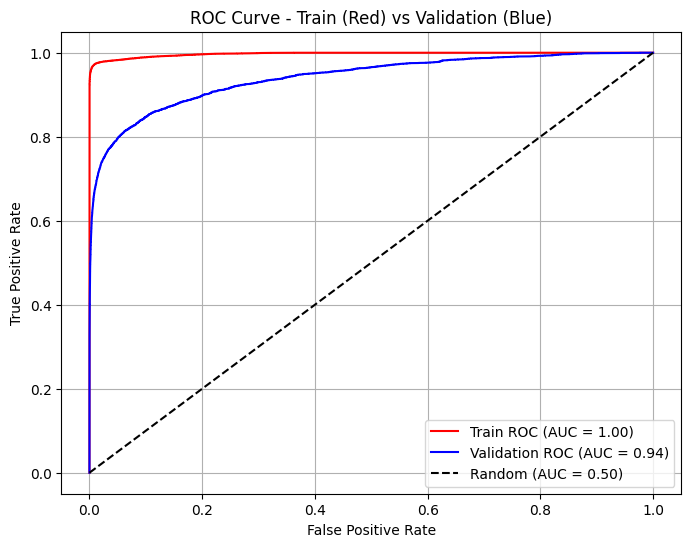

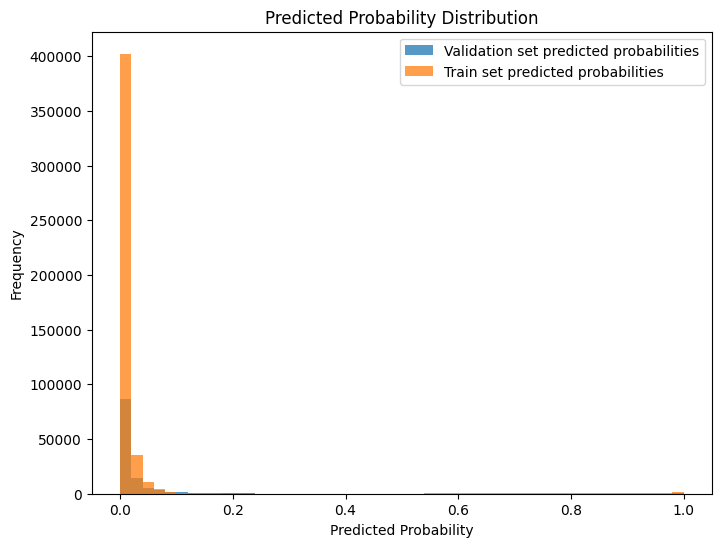

🏃 View run RandomForest_Model at: https://dagshub.com/zhorzholianimate/IEEE-CIS-Fraud-Detection.mlflow/#/experiments/2/runs/3cad836377ad47cebb4865f7680807d3
🧪 View experiment at: https://dagshub.com/zhorzholianimate/IEEE-CIS-Fraud-Detection.mlflow/#/experiments/2


In [72]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

with mlflow.start_run(run_name='RandomForest_Model'):

    mlflow.sklearn.log_model(pipeline, "random_forest_model")

    y_train_proba = pipeline.predict_proba(X_train)[:, 1]
    y_valid_proba = pipeline.predict_proba(X_valid)[:, 1]
    fpr_train, tpr_train, _ = roc_curve(y_train, y_train_proba)
    fpr_valid, tpr_valid, _ = roc_curve(y_valid, y_valid_proba)
    auc_train = auc(fpr_train, tpr_train)
    auc_valid = auc(fpr_valid, tpr_valid)

    mlflow.log_metric("train_auc", auc_train)
    mlflow.log_metric("valid_auc", auc_valid)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr_train, tpr_train, color='red', label=f'Train ROC (AUC = {auc_train:.2f})')
    plt.plot(fpr_valid, tpr_valid, color='blue', label=f'Validation ROC (AUC = {auc_valid:.2f})')
    plt.plot([0, 1], [0, 1], 'k--', label='Random (AUC = 0.50)')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve - Train (Red) vs Validation (Blue)')
    plt.legend(loc='lower right')
    plt.grid(True)
    roc_image_path = "roc_curve.png"
    plt.savefig(roc_image_path)
    mlflow.log_artifact(roc_image_path)
    plt.show()
    plt.close()

    plt.figure(figsize=(8, 6))
    plt.hist(y_valid_proba, bins=50, alpha=0.75, label="Validation set predicted probabilities")
    plt.hist(y_train_proba, bins=50, alpha=0.75, label="Train set predicted probabilities")
    plt.title("Predicted Probability Distribution")
    plt.xlabel("Predicted Probability")
    plt.ylabel("Frequency")
    plt.legend(loc="upper right")
    prob_dist_image_path = "probability_distribution.png"
    plt.savefig(prob_dist_image_path)
    mlflow.log_artifact(prob_dist_image_path)
    plt.show()
    plt.close()

    mlflow.log_param("corelation_filter_threshold", 0.9)
    mlflow.log_param("variation_filter_threshold", 0.05)
    mlflow.log_param("preprocess_steps", [name for name, _ in preprocess.steps])
    mlflow.log_param("drop_high_nan", "enabled")
    mlflow.log_param("drop_high_nan_threashold", "0.8")
    num_imputer = imputer.named_transformers_['num']
    mlflow.log_param("num_imputer_strategy", num_imputer.strategy)
    cat_imputer = imputer.named_transformers_['cat']
    mlflow.log_param("cat_imputer_strategy", cat_imputer.strategy)
    mlflow.log_param("cat_imputer_fill_value", cat_imputer.fill_value)
    mlflow.log_param("categorical_encoder", "FrequencyEncoder()")
    mlflow.log_param("feature_selection", "RandomForestFeatureSelector")
    mlflow.log_param("feature_selection_importance", 1e-4)
    mlflow.log_param("model_max_depth", 40)
    mlflow.log_param("n_estimators", 300)
    mlflow.log_param("model_random_state", 42)